In [2]:
import kepler_utils.yields.janka as janka
import scipy.interpolate
import kepler_utils.yields.yields as yld
import kepler_utils.yields.integrator as integrator
import astropy.units as u
import numpy as np
import astropy.constants as consts

janka_dir = "/Users/justinbrown/Dropbox/Research/Stan/Nucleosynthesis/links14/"
janka_calibrations = ["w15.0", "w18.0", "w20.0", "n20.0"]

lower_sn_limit = 8
remnant_approximation = "si"

for calibration in janka_calibrations:
    jp = None
    jps = []
    janka_files = ["results_%s_revised.txt" % calibration]
    for f in janka_files:
        jps.append (janka.JankaParser.readFrom (janka_dir + f))
        if jp is None:
            jp = jps [-1]
        else:
            jp += jps [-1]

    janka_imf = integrator.IMFIntegrator (jp [":M"])
    
    print ("Calibration: ", calibration)
    
    print ("E", janka_imf (jp [":E_exp"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True))
    
    print ("Ni Mass", janka_imf (jp [":with_fallback:M_outside(Ni)"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True), janka_imf (jp [":with_fallback:M_outside(Ni)"] + jp [":with_fallback:M_outside(Tr)"], mask = jp [":E_exp"] > 0.0 * u.erg, mask_frequency = True))
    
    newmasses = jp [":M"]
    new_imf = janka_imf
    mask = jp [":E_exp"].value > 0
    print ("Average Star Mass", new_imf (newmasses))
    print ("Average SN Mass", new_imf (newmasses, mask = mask, mask_frequency = True))

    print ("%", new_imf (newmasses / newmasses, mask = mask), new_imf (newmasses / newmasses, mask = np.logical_and (newmasses > 20.0 * u.solMass, mask)) / new_imf (newmasses / newmasses, mask = mask))
    print (new_imf (newmasses / newmasses, mask = np.logical_and (newmasses > 20.0 * u.solMass, mask)) / new_imf (newmasses / newmasses, mask = mask))
    
    wdata = np.genfromtxt ("../wcores.dat", names = True)
    w_imf = integrator.IMFIntegrator (wdata ["Minit"] * u.solMass)
    w_remnants = wdata [remnant_approximation] * u.solMass
        
    baryonic_masses = u.Quantity (list (w_remnants) + list (jp [":with_fallback:M_mass_cut_after_fb"]))
    
    baryonic_masses [baryonic_masses > 2.5 * u.solMass] = 0. * u.solMass
    integrated_baryonic_mass = (w_imf + janka_imf) (baryonic_masses, mask = baryonic_masses > 0.0 * u.solMass, mask_frequency = True)
    print ("M_remnant", integrated_baryonic_mass, integrated_baryonic_mass * (1 - 3.0 / 5.0 * consts.G * integrated_baryonic_mass / (12 * u.km * consts.c ** 2)))
    
#     full_imf = integrator.IMFIntegrator (np.arange (9,15,0.1) * u.solMass)) + 
    
#     mask = np.array (list (np.arange (9,15,0.1)>0) + list (jp [":E_exp"].value > 0)), dtype = bool)
#     print (new_imf (newmasses, mask = mask, mask_frequency = True))
#     print (new_imf (newmasses / newmasses, mask = mask))

Calibration:  w15.0
E 7.020825074388177e+50 erg
Ni Mass 0.04340067494865211 solMass 0.054144920212918606 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 14.40349659270851 solMass
% 0.6321283734419516 0.08695786396950189
0.08695786396950189
M_remnant 1.5385486901607475 solMass 1.3637317573827592 solMass
Calibration:  w18.0
E 7.393352094162265e+50 erg
Ni Mass 0.045985653779243414 solMass 0.057612915654103855 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 14.59030823254528 solMass
% 0.6454122115866211 0.1002233947383398
0.1002233947383398
M_remnant 1.5441815777822332 solMass 1.368082232866112 solMass
Calibration:  w20.0
E 5.998032785730114e+50 erg
Ni Mass 0.0357769104951432 solMass 0.043524129422073156 solMass
Average Star Mass 21.588314017547575 solMass
Average SN Mass 12.364339343151762 solMass
% 0.49485399894005083 0.03971822283803301
0.03971822283803301
M_remnant 1.5387882592043287 solMass 1.3639168803287922 solMass
Calibration:  n20.0
E 8.93

In [1]:
import numpy as np
from pandas import read_csv

data = read_csv ("../nucleo.dat", header = 1, index_col = "grid", sep = r"\s{2,}", engine = "python")
data = data.replace ("---", 0.0).fillna (0.0)
data.columns = map (str.lower, data.columns)
data.pop ("network")
v = data.pop ("stability")

data ["ca44"] = data.pop ("ti44")
data ["ti48"] = data.pop ("cr48")
data ["cr52"] = data.pop ("fe52")
data ["fe56"] += data.pop ("ni56")

dmass = np.concatenate ([np.diff (data ["cell outer total mass"]), [0.]])

for key in data.keys ():
    if key [:4] == "cell":
        data.pop (key)
v = data.pop ("'fe'")

prod = data.mul (dmass, axis = 0).sum ()

In [2]:
from kepler_utils.yields.yields import CompositeYieldReader, Isotope
import astropy.units as u

total = CompositeYieldReader ([u.Quantity ([15.2], u.solMass)], [Isotope.fromList (prod.keys ())], [[prod]], scale = u.g.to (u.solMass))

In [6]:
a = data [:np.argmax (data ["s32"] + data ["si28"] > 0.01)].mean ()
a = a * (0.078684 * u.solMass - total.get_yield ("fe56")).to (u.g).value / a ["fe56"] + prod

combined = CompositeYieldReader ([u.Quantity ([15.2], u.solMass)], [Isotope.fromList (a.keys ())], [[a]], scale = u.g.to (u.solMass))

1.0
1.0


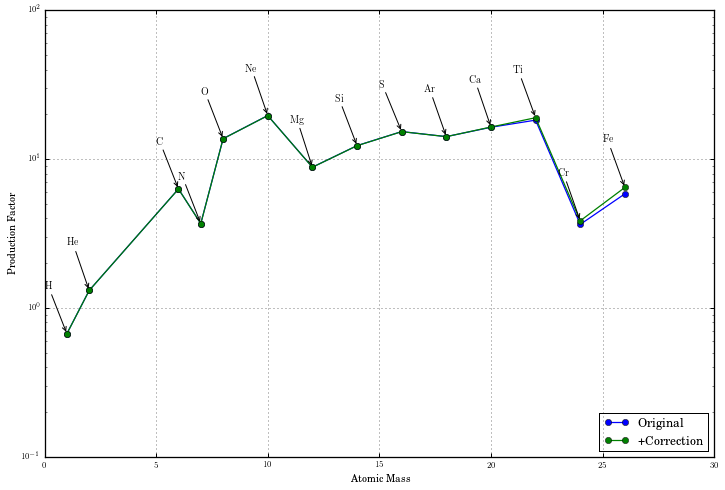

In [13]:
from kepler_utils.plots.yields import YieldPlot
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots (1, 1, sharex = True, figsize = (12, 8))

colors = iter (["blue", "green"])

for yr in [total, combined]:
    p = YieldPlot (yr)
    p.plot (axis, c = next (colors), names = yr == combined, label = "+Correction" if yr == combined else "Original")
    
axis.legend (loc = "lower right")

In [19]:
(0.078684 * u.solMass - total.get_yield ("fe56")).to (u.g).value / a ["fe56"]

array([  2.50341362e+31])

In [18]:
a = data [:np.argmax (data ["s32"] + data ["si28"] > 0.01)].mean ()

In [42]:
syr.yields

,al27,ar36,ar38,ar40,as75,b10,b11,be9,br79,br81,...,w183,w184,w186,yb168,yb170,yb171,yb172,yb173,yb174,yb176
36,0.004554,0.013115,0.004605,0.000003,0.000001,3.142000e-09,0.000002,2.489000e-10,0.000001,0,...,1.390000e-09,2.921000e-09,2.996000e-09,1.789000e-11,6.221000e-10,2.249000e-09,3.542000e-09,2.526000e-09,5.549000e-09,2.302000e-09


In [45]:
syr.yields

,al27,ar36,ar38,ar40,as75,b10,b11,be9,br79,br81,...,w183,w184,w186,yb168,yb170,yb171,yb172,yb173,yb174,yb176
36,0.004554,0.0131,0.004605,0.000003,0.000001,3.142000e-09,0.000002,2.489000e-10,0.000001,0,...,1.390000e-09,2.921000e-09,2.996000e-09,1.789000e-11,6.221000e-10,2.249000e-09,3.542000e-09,2.526000e-09,5.549000e-09,2.302000e-09


In [35]:
syr.yields.iloc [0].add (final, fill_value = 0) ["h1"]

14.166000000000711

AttributeError: 'module' object has no attribute 'Neutrons'

In [64]:
len (np.concatenate ([np.diff (data ["cell outer total mass"]), [0.]]))

951

In [70]:
from pandas import Series

Series (np.concatenate ([np.diff (data ["cell outer total mass"]), [0.]]))

0     7.535326e+29
1     6.481451e+29
2     7.137171e+29
3     4.954377e+29
4     5.066870e+29
5     5.181917e+29
6     5.094204e+29
7     5.364801e+29
8     5.649771e+29
9     6.373814e+29
10    6.853864e+29
11    7.370070e+29
12    6.359052e+29
13    6.959437e+29
14    7.616508e+29
...
936    9.959768e+30
937    9.675663e+30
938    7.426520e+30
939    4.503633e+30
940    3.253348e+30
941    2.406918e+30
942    1.546579e+30
943    8.631041e+29
944    5.090813e+29
945    6.563237e+29
946    5.186156e+29
947    4.497628e+29
948    4.280870e+29
949    5.473752e+29
950    0.000000e+00
Length: 951, dtype: float64

In [73]:
b

0     7.535326e+29
1     6.481451e+29
2     7.137171e+29
3     4.954377e+29
4     5.066870e+29
5     5.181917e+29
6     5.094204e+29
7     5.364801e+29
8     5.649771e+29
9     6.373814e+29
10    6.853864e+29
11    7.370070e+29
12    6.359052e+29
13    6.959437e+29
14    7.616508e+29
...
936    9.959768e+30
937    9.675663e+30
938    7.426520e+30
939    4.503633e+30
940    3.253348e+30
941    2.406918e+30
942    1.546579e+30
943    8.631041e+29
944    5.090813e+29
945    6.563237e+29
946    5.186156e+29
947    4.497628e+29
948    4.280870e+29
949    5.473752e+29
950    0.000000e+00
Length: 951, dtype: float64

In [105]:
data ["stability"]

grid
0:              0
1:      radiative
2:      radiative
3:      radiative
4:      radiative
5:      radiative
6:      radiative
7:      radiative
8:      radiative
9:      radiative
10:     radiative
11:     radiative
12:     radiative
13:     radiative
14:     radiative
...
936:    radiative
937:    radiative
938:    radiative
939:    radiative
940:    radiative
941:    radiative
942:    radiative
943:    radiative
944:    radiative
945:    radiative
946:    radiative
947:    radiative
948:    radiative
949:    radiative
950:    radiative
Name: stability, Length: 951, dtype: object

In [111]:
prod

,neutrons,h1,he3,he4,c12,n14,o16,ne20,mg24,si28,s32,ar36,ca40,ti44,cr48,fe52,fe54,ni56,fe56,'fe'
grid,,,,,,,,,,,,,,,,,,,,
0:,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
1:,0.000016,1.683452e+19,0.000000e+00,1.996036e+29,2.732664e+26,0.000000e+00,7.491647e+23,1.363253e+24,4.189151e+24,9.869067e+25,3.263884e+26,3.024133e+26,3.226064e+27,1.098599e+27,1.318352e+27,2.493954e+27,9.555196e+26,4.384421e+29,0,0
2:,0.000018,1.303072e+19,0.000000e+00,1.800849e+29,2.148557e+26,0.000000e+00,5.842885e+23,1.052855e+24,3.199028e+24,7.643801e+25,2.533320e+26,2.371486e+26,2.622496e+27,9.068395e+26,1.108028e+27,2.115531e+27,1.051579e+27,5.250412e+29,0,0
3:,0.000012,7.330467e+18,0.000000e+00,1.154336e+29,1.388093e+26,0.000000e+00,3.771898e+23,6.791978e+23,2.061713e+24,4.924625e+25,1.630108e+26,1.524498e+26,1.682710e+27,5.816144e+26,7.122435e+26,1.354933e+27,7.309392e+26,3.744351e+29,0,0
4:,0.000013,5.954485e+18,0.000000e+00,1.073743e+29,1.304510e+26,0.000000e+00,3.542341e+23,6.373433e+23,1.932688e+24,4.610245e+25,1.523155e+26,1.422613e+26,1.565971e+27,5.407937e+26,6.640386e+26,1.257986e+27,7.482807e+26,3.940615e+29,0,0
5:,0.000013,6.799718e+18,0.000000e+00,1.157055e+29,1.390845e+26,0.000000e+00,3.774796e+23,6.789259e+23,2.058760e+24,4.927150e+25,1.629836e+26,1.523615e+26,1.679963e+27,5.811141e+26,7.126156e+26,1.348154e+27,7.646868e+26,3.968928e+29,0,0
6:,0.000014,7.805446e+18,0.000000e+00,1.220957e+29,1.448445e+26,0.000000e+00,3.929061e+23,7.063931e+23,2.142147e+24,5.146402e+25,1.704760e+26,1.595405e+26,1.762575e+27,6.108137e+26,7.478444e+26,1.412800e+27,7.507574e+26,3.815104e+29,0,0
7:,0.000015,9.303699e+18,0.000000e+00,1.365060e+29,1.600866e+26,0.000000e+00,4.340272e+23,7.799431e+23,2.365029e+24,5.700937e+25,1.890361e+26,1.770640e+26,1.958981e+27,6.799285e+26,8.314540e+26,1.567955e+27,7.902732e+26,3.935588e+29,0,0
8:,0.000015,1.138667e+19,0.000000e+00,1.551462e+29,1.795094e+26,0.000000e+00,4.864361e+23,8.736455e+23,2.649062e+24,6.409369e+25,2.127485e+26,1.994723e+26,2.210306e+27,7.683810e+26,9.383153e+26,1.766267e+27,8.318887e+26,4.026559e+29,0,0
